# **0. Pre-Setup**
1. Before starting using this .ipynb, you should create a project using your google credentials by following this step https://cloud.google.com/appengine/docs/standard/nodejs/building-app/creating-project (you can skip the setup billing account, all of analysis below can be perform using free project account)
2. Replace below project_id = 'mynetappproject202012' with your project ID
3. Run the code and authenticate your account as the user by entering the verification code

In [1]:
from google.colab import auth
auth.authenticate_user()
project_id = 'mynetappproject202012'

In [2]:
!pip install geopandas
!pip install pyshp
!pip install shapely

     |████████████████████████████████| 972kB 5.5MB/s 
     |████████████████████████████████| 14.8MB 292kB/s 
     |████████████████████████████████| 6.5MB 49.6MB/s 
     |████████████████████████████████| 225kB 6.0MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.2-cp36-none-any.whl size=36216 sha256=25c07e47379efa6fe1649d4c2a4b7f796b7dd1eac883590f692c8e253352fe71
  Stored in directory: /root/.cache/pip/wheels/96/6c/53/4112475adf3b831da97f083163d0f38ee6daac9c1b13f7afea
Successfully built pyshp


# **1. Importing bigquery library and other necessary library**
This code was build by referencing the workshop/hands on Lab from https://cloudonair.withgoogle.com/events/health-datasets that was build by Shane Glass

In [3]:
from google.cloud import bigquery
import geopandas
import numpy as np
import pandas as pd
import json
from shapely import wkt
from shapely import geometry
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
client = bigquery.Client (project = project_id)
print ('setup succeded')

setup succeded


# **2. Understanding all of the tables from the biquery-public-data that will be used in this analysis**
1. noaa_hurricanes (it is list of hurricanes that occured in the US througout the years)
2. geo_international_ports.world_port_index (where the country is US and the region number is the east-cost of US

In [ ]:
historic_hurricane_query = """
SELECT
  *
FROM
  `bigquery-public-data.noaa_hurricanes.hurricanes`
WHERE
  basin = "NA" AND
  name != "NOT_NAMED"
LIMIT 1
"""
historic_hurricane = client.query(historic_hurricane_query).to_dataframe()
historic_hurricane.head()

,sid,season,number,basin,subbasin,name,iso_time,nature,latitude,longitude,wmo_wind,wmo_pressure,wmo_agency,track_type,dist2land,landfall,iflag,usa_agency,usa_latitude,usa_longitude,usa_record,usa_status,usa_wind,usa_pressure,usa_sshs,usa_r34_ne,usa_r34_se,usa_r34_sw,usa_r34_nw,usa_r50_ne,usa_r50_se,usa_r50_sw,usa_r50_nw,usa_r64_ne,usa_r64_se,usa_r64_sw,usa_r64_nw,usa_poci,usa_roci,usa_rmw,...,bom_roci,bom_poci,bom_eye,bom_pos_method,bom_pressure_method,wellington_latitude,wellington_longitude,wellington_wind,wellington_pressure,nadi_latitude,nadi_longitude,nadi_cat,nadi_wind,nadi_pressure,ds824_latitude,ds824_longitude,ds824_stage,ds824_wind,ds824_pressure,td9636_latitude,td9636_longitude,td9636_stage,td9636_wind,td9636_pressure,td9635_latitude,td9635_longitude,td9635_wind,td9635_pressure,td9635_roci,neumann_latitude,neumann_longitude,neumann_class,neumann_wind,neumann_pressure,mlc_latitude,mlc_longitude,mlc_class,mlc_wind,mlc_pressure,usa_atcf_id
0,1960261N21296,1960,72,NA,NA,FLORENCE,1960-09-23 06:00:00+00:00,NR,24.0,-82.6,25,None,hurdat_atl,main,101,101,O_____________,hurdat_atl,24.0,-82.6,,DB,25,None,-3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,None,None,,None,None,AL071960
1,1980214N11330,1980,57,NA,NA,ALLEN,1980-07-31 12:00:00+00:00,NR,11.0,-30.0,25,None,hurdat_atl,main,1417,1417,O_____________,hurdat_atl,11.0,-30.0,,DB,25,None,-3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,None,None,,None,None,AL041980


In [ ]:
east_coast_ports_query = """
SELECT 
  *
FROM
  `bigquery-public-data.geo_international_ports.world_port_index`
WHERE
  country = 'US'
  and region_number = '6585'
  and shelter_afforded IN ("E", "G")
lIMIT 1
"""
east_coast_ports = client.query(east_coast_ports_query).to_dataframe()
east_coast_ports.head()

,index_number,region_number,port_name,country,port_latitude,port_longitude,publication_number,chart_number,harbor_size,harbor_type,shelter_afforded,entry_tide,entry_swell,entry_ice,entry_other,overhead_limit,channel_depth,anchorage_depth,cargo_pier_depth,cargo_oil_depth,tide_range,max_vessel_size,good_holding_ground,turning_area,port_of_entry,us_representative,eta_message_required,pilot_required,pilot_available,pilot_local_assist,pilot_advised,tug_salvage,tug_assist,quarantine_procedures_required,quarantine_sscc_cert_required,quarantine_other,comms_phone,comms_fax,comms_radio,comms_vhf,comms_air,comms_rail,cargo_wharf,cargo_anchor,cargo_med_moor,cargo_beach_moor,cargo_ice_moor,med_facility,garbage_dispose,degauss,dirty_ballast,crane_fixed,crane_mobile,crane_float,lift_100_tons,lift_50_100_tons,lift_25_49_tons,lift_0_24_tons,services_longshore,services_electrical,services_steam,services_nav_equip,services_electrical_repair,provisions,water,fuel_oil,diesel,deck_supplies,eng_supplies,repair_types,dry_dock_types,railway_types,port_geom
0,8570,6585,MAYPORT,US,30.400000,-81.433333,CP04,11490,V,RN,E,False,False,False,True,True,H,H,H,None,5,L,None,True,False,False,False,True,None,None,None,None,True,True,True,None,True,None,None,True,None,None,True,None,None,None,None,True,None,None,False,None,None,None,None,None,None,None,None,None,None,None,None,True,True,True,True,True,True,None,None,None,POINT(-81.4333333333333 30.4)
1,8180,6585,CAPE CHARLES,US,37.266667,-76.016667,CP03,12224,V,CN,E,False,False,False,True,False,N,O,O,None,2,M,None,True,True,False,False,True,None,None,None,None,None,True,True,None,True,None,None,None,None,True,True,None,None,None,None,True,None,None,False,None,None,None,None,None,None,None,None,None,None,None,None,True,True,True,True,None,None,None,None,None,POINT(-76.0166666666667 37.2666666666667)


In [7]:
#convert the usa_r34_ne (etc) that stored in `bigquery-public-data.noaa_hurricanes.hurricanes` to nautical_miles unit using function from `bigquery-public-data.persistent_udfs.nautical_miles_conversion`
hurricane_miles_convert_query = """
  SELECT
    sid AS storm_id,
    latitude,
    longitude,
    `bigquery-public-data.persistent_udfs.nautical_miles_conversion`(usa_r34_ne) AS usa_r34_ne,
    `bigquery-public-data.persistent_udfs.nautical_miles_conversion`(usa_r34_se) AS usa_r34_se,
    `bigquery-public-data.persistent_udfs.nautical_miles_conversion`(usa_r34_sw) AS usa_r34_sw,
    `bigquery-public-data.persistent_udfs.nautical_miles_conversion`(usa_r34_nw) AS usa_r34_nw
  FROM
    `bigquery-public-data.noaa_hurricanes.hurricanes`
  WHERE
    basin = "NA" AND
    name != "NOT_NAMED" AND
    usa_wind >= 35 AND
    usa_sshs >= -1
  ORDER BY
    usa_r34_nw desc
  LIMIT 1
"""
hurricane_miles_convert = client.query(hurricane_miles_convert_query).to_dataframe()
hurricane_miles_convert.head()

,storm_id,latitude,longitude,usa_r34_ne,usa_r34_se,usa_r34_sw,usa_r34_nw
0,2016278N23300,39.1,-48.0,414.2808,379.7574,345.234,483.3276


# **3. Put All together**
0. Final objective of this project is to determine where is the safest location of port from hurricanes. In that way, company can decide to build new warehouse near port location with the safest condition.
1. Create new tables using hurricanes, port, and conversion function (nautical_miles, azimuth_to_geog_point) and named it as hurricanes_and_ports
2. create the geometry of port (black dot) and hurricanes (hot polygon) by using geopandas.GeoDataFram
3. Draw above geometry on top of North-America Map
4. Now, the decision can be made. From the final picture, it can be seen that the soutest of the east-coast is the optimum location. Then company can go to details where is the most optimum location.

In [8]:
query_params = [
  bigquery.ScalarQueryParameter("ne", "INT64", 45),
  bigquery.ScalarQueryParameter("se", "INT64", 135),
  bigquery.ScalarQueryParameter("sw", "INT64", 225),
  bigquery.ScalarQueryParameter("nw", "INT64", 315)
]
hurricanes_and_ports_query = """
  with convert_miles AS(
    SELECT
      sid AS storm_id,
      season,
      latitude,
      longitude,
      `bigquery-public-data.persistent_udfs.nautical_miles_conversion`(usa_r34_ne) AS usa_r34_ne,
      `bigquery-public-data.persistent_udfs.nautical_miles_conversion`(usa_r34_se) AS usa_r34_se,
      `bigquery-public-data.persistent_udfs.nautical_miles_conversion`(usa_r34_sw) AS usa_r34_sw,
      `bigquery-public-data.persistent_udfs.nautical_miles_conversion`(usa_r34_nw) AS usa_r34_nw
    FROM
      `bigquery-public-data.noaa_hurricanes.hurricanes`
    WHERE
      basin = "NA" AND
      name != "NOT_NAMED" AND
      usa_wind >= 35 AND
      usa_sshs >= -1),
    
  ts_wind_polygon AS(
    SELECT
      storm_id,
      season,
      ST_MakePolygon(
        ST_MakeLine([
          `bigquery-public-data.persistent_udfs.azimuth_to_geog_point` (latitude, longitude, @ne,  usa_r34_ne),
          `bigquery-public-data.persistent_udfs.azimuth_to_geog_point` (latitude, longitude, @se,  usa_r34_se),
          `bigquery-public-data.persistent_udfs.azimuth_to_geog_point` (latitude, longitude, @sw,  usa_r34_sw),
          `bigquery-public-data.persistent_udfs.azimuth_to_geog_point` (latitude, longitude, @nw,  usa_r34_nw)]
          )
        ) tropical_storm_geom
      FROM
        convert_miles)

  SELECT
    index_number, 
    port_name,
    state_name,
    STRING_AGG (DISTINCT(h.season)) AS storm_years,
    COUNT(DISTINCT(storm_id)) AS count_storms,
    STRING_AGG (DISTINCT(name)) AS storm_name,
    AVG(usa_sshs) AS avg_storm_cat,
    AVG(usa_wind) AS avg_wind_speed,
    ST_AsText(port_geom) AS port_geom,
    ST_AsText(tropical_storm_geom) AS tropical_storm_geom
  FROM
    ts_wind_polygon t,
    `bigquery-public-data.geo_international_ports.world_port_index`,
    `bigquery-public-data.geo_us_boundaries.states`
  JOIN
    `bigquery-public-data.noaa_hurricanes.hurricanes` h ON h.sid = t.storm_id
  WHERE
    port_name IS NOT NULL
    AND region_number = '6585'
    AND shelter_afforded IN ("E", "G")
    AND ST_WITHIN(port_geom, state_geom)
    AND ST_WITHIN(port_geom, tropical_storm_geom)
  GROUP BY
    index_number,
    port_geom, 
    port_name,
    state_name,
    tropical_storm_geom
  ORDER BY
    index_number
"""
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params

hurricanes_and_ports = client.query(hurricanes_and_ports_query,job_config).to_dataframe()
hurricanes_and_ports

,index_number,port_name,state_name,storm_years,count_storms,storm_name,avg_storm_cat,avg_wind_speed,port_geom,tropical_storm_geom
0,6610,LUBEC,Maine,2020,1,TEDDY,0.315315,65.558559,POINT(-66.9833333333333 44.8666666666667),"POLYGON((-70.9185918801134 45.6468877799488, -..."
1,6610,LUBEC,Maine,2020,1,TEDDY,0.315315,65.558559,POINT(-66.9833333333333 44.8666666666667),"POLYGON((-70.2225135029574 45.0704817638454, -..."
2,6610,LUBEC,Maine,2008,1,KYLE,-0.733333,50.977778,POINT(-66.9833333333333 44.8666666666667),"POLYGON((-67.7869083988451 45.5832695772166, -..."
3,6610,LUBEC,Maine,2009,1,BILL,0.795455,76.954545,POINT(-66.9833333333333 44.8666666666667),"POLYGON((-67.6690276188381 45.1635990464247, -..."
4,6610,LUBEC,Maine,2010,1,EARL,0.547170,67.245283,POINT(-66.9833333333333 44.8666666666667),"POLYGON((-67.5713345818163 45.5798410749909, -..."
...,...,...,...,...,...,...,...,...,...,...
1871,8640,MIAMI,Florida,2004,1,FRANCES,1.218310,76.394366,POINT(-80.1833333333333 25.7833333333333),"POLYGON((-81.7410626981474 28.8610015182289, -..."
1872,8640,MIAMI,Florida,2017,1,IRMA,2.463415,98.650407,POINT(-80.1833333333333 25.7833333333333),"POLYGON((-85.1118468990161 27.1456337890789, -..."
1873,8640,MIAMI,Florida,2005,1,KATRINA,1.187500,73.875000,POINT(-80.1833333333333 25.7833333333333),"POLYGON((-80.9375396059438 26.5283770931561, -..."
1874,8640,MIAMI,Florida,2017,1,IRMA,2.463415,98.650407,POINT(-80.1833333333333 25.7833333333333),"POLYGON((-83.6711210374337 30.2689412669939, -..."


In [9]:
hurricanes_and_ports ['port_geom'] = hurricanes_and_ports ['port_geom'].apply(wkt.loads)
ports_geo =geopandas.GeoDataFrame(hurricanes_and_ports, geometry = 'port_geom')

hurricanes_and_ports['tropical_storm_geom'] = hurricanes_and_ports['tropical_storm_geom'].apply(wkt.loads)
hurricanes_geo = geopandas.GeoDataFrame(hurricanes_and_ports, geometry = 'tropical_storm_geom')

<function matplotlib.pyplot.show>

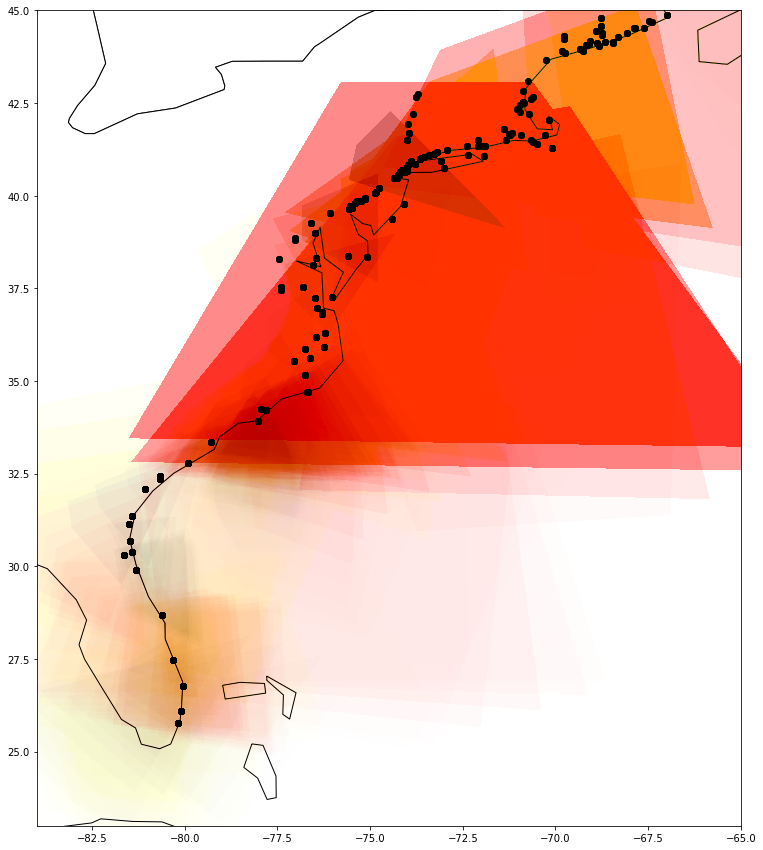

In [10]:
x_max = -65
x_min = -84
y_min = 23
y_max = 45

ax = world[world.continent== 'North America'].plot(
    figsize = (15,15), color ='white', edgecolor = 'black'
)
ax = ports_geo.plot(color = 'black', ax=ax, legend=False)
hurricanes_geo.plot(column = 'avg_wind_speed', cmap='hot', ax=ax, legend = False, alpha=.003)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.show
